# Dependências

In [ ]:
%pip install unidecode

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 3.7 MB/s eta 0:00:00


In [ ]:
%pip install spacy

In [ ]:
%%python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 18.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from unidecode import unidecode
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import RSLPStemmer
import spacy
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score, ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.naive_bayes import MultinomialNB
import sklearn as sk
import matplotlib.pyplot as plt

nlp = spacy.load('en_core_web_sm')
nltk.download('rslp')

[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Package rslp is already up-to-date!


True

# Dados

In [ ]:
# url = 'https://docs.google.com/spreadsheets/d/1AZJ5QU8MwpLdtnYsmGpx4FaefXzB-RrhnG-ENoAK-n4/export?format=xlsx'
url = 'https://docs.google.com/spreadsheets/d/1JXD4d24u7PKOnkHViyIW2ppyAXiv7GW9fJa4nFtyJKY/export?format=xlsx'
data = pd.read_excel(url, engine='openpyxl')
df = pd.DataFrame(data)

# Analise Exploratória dos dados

Verificação dos dados e tratamento.

In [ ]:
# Verificação de dados nulos
df.isna().sum()

none          0
none.1        0
Sentiment     0
Text         19
dtype: int64

In [ ]:
# Remoção de linhas com dados nulos
df = df[df['Text'].notna()]
df.isna().sum()

none         0
none.1       0
Sentiment    0
Text         0
dtype: int64

In [ ]:
# Linhas onde o tipo de ['Text'] não é str
for _, i in df.iterrows():
    if type(i['Text']) != str:
        print(i)

In [ ]:
# Remove as linhas onde o tipo de ['Text'] não é str
df = df[df['Text'].apply(lambda x: isinstance(x, str))]

Agora que os dados já estão tratados, vamos definir os dados de treinamento.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df['Text'], df['Sentiment'], test_size=0.2, random_state=42)

In [ ]:
# Verifica o tamanho do X_train e y_train para garantir que não haja divergência de valores
print(f"Tamanho de X_train: {len(X_train)}")
print(f"Tamanho de y_train: {len(y_train)}")

Tamanho de X_train: 2384
Tamanho de y_train: 2384


Visualização dos dados:

In [ ]:
df.head()

,none,none.1,Sentiment,Text
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [ ]:
lista = data['Sentiment'].unique()
lista2 = []

# Itera em cada linha para obter a quanidade de textos pra cada sentimento
for i in data['Sentiment'].unique():
    count = 0
    for _, row in data.iterrows():
        if row['Sentiment'] == i:
            count += 1
    print(f"SENTIMENTO {i}: {count}")
    lista2.append(count)

SENTIMENTO Positive: 1235
SENTIMENTO Neutral: 714
SENTIMENTO Negative: 606
SENTIMENTO Irrelevant: 444


Através da figura abaixo, podemos visualizar que os dados estão balanceados.

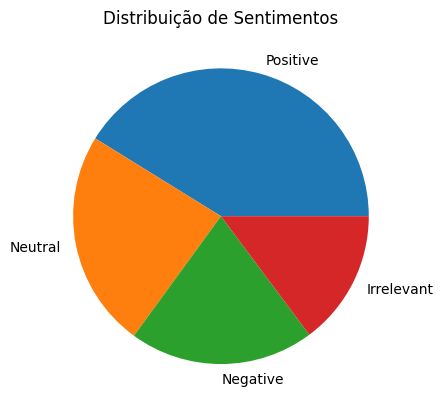

In [ ]:
fig, ax = plt.subplots()
ax.pie(lista2, labels=lista)
ax.set_title('Distribuição de Sentimentos')
plt.show()

# Pré-processamento dos dados

In [ ]:

print(f'Teste 1: {len(X_train)}')
print(f'Teste 1: {len(y_train)}')

# Remoção de números, caracteres especiais e conversão para minúscula
X_train_clear = [re.sub(r'[^a-zA-Z\s]', '', text).lower() for text in X_train]
X_test_clear = [re.sub(r'[^a-zA-Z\s]', '', text).lower() for text in X_test]

print(f'Teste 2: {len(X_train_clear)}')
print(f'Teste 2: {len(y_train)}')

# Tokenização
X_train_tk = [phrase.split() for phrase in X_train_clear]
X_test_tk = [phrase.split() for phrase in X_test_clear]

print(f'Teste 3: {len(X_train_tk)}')
print(f'Teste 3: {len(y_train)}')

# Remoção de Stop Words
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
X_train_sw = [[word for word in phrase if word not in stop_words] for phrase in X_train_tk]
X_test_sw = [[word for word in phrase if word not in stop_words] for phrase in X_test_tk]

print(f'Teste 4: {len(X_train_sw)}')
print(f'Teste 4: {len(y_train)}')

# Stemização
stemmer = RSLPStemmer()
X_train_sm = [[stemmer.stem(word) for word in phrase] for phrase in X_train_sw]
X_test_sm = [[stemmer.stem(word) for word in phrase] for phrase in X_test_sw]

print(f'Teste 5: {len(X_train_sm)}')
print(f'Teste 5: {len(y_train)}')

# Lematização com correção para minúsculas

X_train_lm = [' '.join([token.lemma_.lower() for token in nlp(' '.join(phrase))]) for phrase in X_train_sm]
X_test_lm = [' '.join([token.lemma_.lower() for token in nlp(' '.join(phrase))]) for phrase in X_test_sm]


print(f'Teste 6: {len(X_train_lm)}')
print(f'Teste 6: {len(y_train)}')



Teste 1: 2384
Teste 1: 2384
Teste 2: 2384
Teste 2: 2384
Teste 3: 2384
Teste 3: 2384


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Teste 4: 2384
Teste 4: 2384
Teste 5: 2384
Teste 5: 2384
Teste 6: 2384
Teste 6: 2384


# **k-NN + TF-IDF**

Vetorização através do TF-IDF

In [ ]:
vectorizer = TfidfVectorizer()
X_train_vec = vectorizer.fit_transform(X_train_lm)
X_test_vec = vectorizer.transform(X_test_lm)

Implementação do k-NN

In [ ]:
# Definição do classificador k-NN
knn = KNeighborsClassifier(n_neighbors=5)

# Treinamento do modelo
knn.fit(X_train_vec, y_train)

# Predição
y_pred = knn.predict(X_test_vec)

# Resultados
knn_tfidf = (y_test, y_pred)

# **k-NN + BoW**


Vetorização através do BoW

In [ ]:
vectorizer = CountVectorizer()
X_train_vec = vectorizer.fit_transform(X_train_lm)
X_test_vec = vectorizer.transform(X_test_lm)

Implementação do k-NN

In [ ]:
# Definição do classificador k-NN
knn = KNeighborsClassifier(n_neighbors=5)

# Treinamento do modelo
knn.fit(X_train_vec, y_train)

# Predição
y_pred = knn.predict(X_test_vec)

# Resultados
knn_bow = (y_test, y_pred)

# **Árvore de decisão + TF-IDF**

Vetorização através do TF-IDF

In [ ]:
vectorizer = TfidfVectorizer()
X_train_vec = vectorizer.fit_transform(X_train_lm)
X_test_vec = vectorizer.transform(X_test_lm)

Implentação da árvore de decisão

In [ ]:
# Definição do classificador Árvore de decisão
tree = DecisionTreeClassifier()

# Treinamento do modelo
tree.fit(X_train_vec, y_train)

# Predição
y_pred = tree.predict(X_test_vec)

# Resultados
tree_tfidf = (y_test, y_pred)

# **Árvore de decisão + BoW**

Vetorização através do BoW

In [ ]:
vectorizer = CountVectorizer()
X_train_vec = vectorizer.fit_transform(X_train_lm)
X_test_vec = vectorizer.transform(X_test_lm)

Implementação da árvore de decisão

In [ ]:
# Definição do classificador Árvore de decisão
tree = DecisionTreeClassifier()

# Treinamento do modelo
tree.fit(X_train_vec, y_train)

# Predição
y_pred = tree.predict(X_test_vec)

# Resultados
tree_bow = (y_test, y_pred)

# **SVM + TF-IDF**

Vetorização através do TF-IDF

In [ ]:
vectorizer = TfidfVectorizer()
X_train_vec = vectorizer.fit_transform(X_train_lm)
X_test_vec = vectorizer.transform(X_test_lm)

Implementação do SVM

In [ ]:
# Definição do classificador SVM
svm = SVC()

# Treinamento do modelo
svm.fit(X_train_vec, y_train)

# Predição
y_pred = svm.predict(X_test_vec)

# Resultados
svm_tfidf = (y_test, y_pred)

# **SVM + BoW**

Vetorização através do BoW

In [ ]:
vectorizer = CountVectorizer()
X_train_vec = vectorizer.fit_transform(X_train_lm)
X_test_vec = vectorizer.transform(X_test_lm)

Implementação do SVM

In [ ]:
# Definição do classificador SVM
svm = SVC()

# Treinamento do modelo
svm.fit(X_train_vec, y_train)

# Predição
y_pred = svm.predict(X_test_vec)

# Resultados
svm_bow = (y_test, y_pred)

# **Naive Bayes + TF-IDF**


In [ ]:
vectorizer = TfidfVectorizer()
X_train_vec = vectorizer.fit_transform(X_train_lm)
X_test_vec = vectorizer.transform(X_test_lm)

Implementação do Naive Bayes

In [ ]:
# Definição do classificador Naive Bayes
nb = MultinomialNB()

# Treinamento do modelo
nb.fit(X_train_vec, y_train)

# Predição
y_pred = nb.predict(X_test_vec)

# Resultados
nb_tfidf = (y_test, y_pred)

# **Naive Bayes + BoW**


In [ ]:
vectorizer = CountVectorizer()
X_train_vec = vectorizer.fit_transform(X_train_lm)
X_test_vec = vectorizer.transform(X_test_lm)

Implementação do Naive Bayes

In [ ]:
# Definição do classificador Naive Bayes
nb = MultinomialNB()

# Treinamento do modelo
nb.fit(X_train_vec, y_train)

# Predição
y_pred = nb.predict(X_test_vec)

# Resultados
nb_bow = (y_test, y_pred)

# **Random Forest + TF-IDF**


Vetorização através do TF-IDF

In [ ]:
vectorizer = TfidfVectorizer()
X_train_vec = vectorizer.fit_transform(X_train_lm)
X_test_vec = vectorizer.transform(X_test_lm)

Implementação do Random Forest

In [ ]:
# Definição do classificador Random Forest
rf = RandomForestClassifier()

# Treinamento do modelo
rf.fit(X_train_vec, y_train)

# Predição
y_pred = rf.predict(X_test_vec)

# Resultados
rf_tfidf = (y_test, y_pred)

# **Random Forest + BoW**


Vetorização através do BoW

In [ ]:
vectorizer = CountVectorizer()
X_train_vec = vectorizer.fit_transform(X_train_lm)
X_test_vec = vectorizer.transform(X_test_lm)

Implementação do Random Forest

In [ ]:
# Definição do classificador Random Forest
rf = RandomForestClassifier()

# Treinamento do modelo
rf.fit(X_train_vec, y_train)

# Predição
y_pred = rf.predict(X_test_vec)

# Resultados
rf_bow = (y_test, y_pred)

# **Resultados**


In [ ]:
# Dicionario com todos os resultados
results = {"k-NN - TF-IDF": knn_tfidf, "k-NN - BoW": knn_bow, "Árvore de decisão - TF-IDF": tree_tfidf, "Árvore de decisão - BoW": tree_bow,
           "SVM - TF-IDF": svm_tfidf, "SVM - BoW": svm_bow, "Naive Bayes - TF-IDF": nb_tfidf, "Naive Bayes - BoW": nb_bow,
           "Random Forest - TF-IDF": rf_tfidf, "Random Forest - BoW": rf_bow}

tfidf = {"k-NN - TF-IDF": knn_tfidf, "Árvore de decisão - TF-IDF": tree_tfidf, "SVM - TF-IDF": svm_tfidf,
         "Naive Bayes - TF-IDF": nb_tfidf, "Random Forest - TF-IDF": rf_tfidf}

bow = {"k-NN - BoW": knn_bow, "Árvore de decisão - BoW": tree_bow, "SVM - BoW": svm_bow,
       "Naive Bayes - BoW": nb_bow, "Random Forest - BoW": rf_bow}

In [ ]:
print("======== RESULTADO GERAL ========")
accuracy_main = []
print()
for i in results:
    print(f'{i}:')
    acc = accuracy_score(results[i][0], results[i][1])
    accuracy_main.append(acc)
    print(f"Acurácia: {acc:.2f}")
    print('----------------------------------')

======== RESULTADO GERAL ========

k-NN - TF-IDF:
Acurácia: 0.91
----------------------------------
k-NN - BoW:
Acurácia: 0.81
----------------------------------
Árvore de decisão - TF-IDF:
Acurácia: 0.80
----------------------------------
Árvore de decisão - BoW:
Acurácia: 0.83
----------------------------------
SVM - TF-IDF:
Acurácia: 0.95
----------------------------------
SVM - BoW:
Acurácia: 0.89
----------------------------------
Naive Bayes - TF-IDF:
Acurácia: 0.81
----------------------------------
Naive Bayes - BoW:
Acurácia: 0.87
----------------------------------
Random Forest - TF-IDF:
Acurácia: 0.94
----------------------------------
Random Forest - BoW:
Acurácia: 0.93
----------------------------------


In [ ]:
print("======== RESULTADO TF-IDF ========")
accuracy_tfidf = []
print()
for i in tfidf:
    print(f'{i}:')
    acc = accuracy_score(tfidf[i][0], tfidf[i][1])
    accuracy_tfidf.append(acc)
    print(f"Acurácia: {acc:.2f}")
    print('----------------------------------')

In [ ]:
print("======== RESULTADO TF-IDF ========")
accuracy_bow = []
print()
for i in bow:
    print(f'{i}:')
    accuracy_score(bow[i][0], bow[i][1])
    acc = accuracy_score(bow[i][0], bow[i][1])
    accuracy_bow.append(acc)
    print(f"Acurácia: {acc:.2f}")
    print('----------------------------------')

In [ ]:
labels = [i for i in results.keys()]

colors = plt.cm.get_cmap('tab10', len(labels))

fig, ax = plt.subplots()
bars = ax.bar(labels, accuracy_main, color=colors(range(len(labels))))
ax.set_ylabel('Acurácia')
ax.set_title('Acurácia por modelo')

legend_labels = [label for label in labels]
ax.legend(bars, legend_labels, loc='center left', bbox_to_anchor=(1, 0.5))

ax.set_yticks(np.arange(0, 1.1, 0.1))

plt.xticks(rotation=-78)
plt.show()

In [ ]:
labels = [i for i in tfidf.keys()]

colors = plt.cm.get_cmap('tab10', len(labels))

fig, ax = plt.subplots()
bars = ax.bar(labels, accuracy_tfidf, color=colors(range(len(labels))))
ax.set_ylabel('Acurácia')
ax.set_title('Acurácia por TF-IDF')

legend_labels = [label for label in labels]
ax.legend(bars, legend_labels, loc='center left', bbox_to_anchor=(1, 0.5))

ax.set_yticks(np.arange(0, 1.1, 0.1))

plt.xticks(rotation=-78)
plt.show()

In [ ]:
labels = [i for i in bow.keys()]

colors = plt.cm.get_cmap('tab10', len(labels))

fig, ax = plt.subplots()
bars = ax.bar(labels, accuracy_bow, color=colors(range(len(labels))))
ax.set_ylabel('Acurácia')
ax.set_title('Acurácia por BoW')

legend_labels = [label for label in labels]
ax.legend(bars, legend_labels, loc='center left', bbox_to_anchor=(1, 0.5))

ax.set_yticks(np.arange(0, 1.1, 0.1))

plt.xticks(rotation=-78)
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score

labels = ['k-NN', 'Árvore de decisão', 'SVM', 'Naive Bayes', 'Random Forest']


bar_width = 0.35
index = np.arange(len(labels))

fig, ax = plt.subplots()

bars1 = ax.bar(index, accuracy_bow, bar_width, label='BoW', color='blue')

bars2 = ax.bar(index + bar_width, accuracy_tfidf, bar_width, label='TF-IDF', color='orange')

ax.set_xlabel('Modelos')
ax.set_ylabel('Acurácia')
ax.set_title('Comparação de Acurácia por Modelo e Vetorização')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(labels, rotation=-45)

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

ax.set_yticks(np.arange(0, 1.1, 0.1))

plt.tight_layout()
plt.show()


In [ ]:
avg_main = np.mean(accuracy_main)
avg_tfidf = np.mean(accuracy_tfidf)
avg_bow = np.mean(accuracy_bow)

labels = ["Main", "TF-IDF", "BoW"]
accuracies = [avg_main, avg_tfidf, avg_bow]

colors = plt.cm.get_cmap('tab10', len(labels))

fig, ax = plt.subplots()
bars = ax.bar(labels, accuracies, color=colors(range(len(labels))))
ax.set_ylabel('Acurácia')
ax.set_title('Média de Acurácia')

legend_labels = [label for label in labels]
ax.legend(bars, legend_labels, loc='center left', bbox_to_anchor=(1, 0.5))

ax.set_yticks(np.arange(0, 1.1, 0.1))

plt.xticks(rotation=-78)
plt.show()
print(f'Média de Acurácia Main: {avg_main:.2f}')
print(f'Média de Acurácia TF-IDF: {avg_tfidf:.2f}')
print(f'Média de Acurácia BoW: {avg_bow:.2f}')

In [ ]:
accuracy_models = []
for i in range(0, len(accuracy_main), 2):
    model = [accuracy_main[i], accuracy_main[i + 1]]
    accuracy_models.append(model)

avg_models = []
for k in accuracy_models:
    avg = np.mean(k)
    avg_models.append(avg)

In [ ]:
avg_main = np.mean(accuracy_main)
avg_tfidf = np.mean(accuracy_tfidf)
avg_bow = np.mean(accuracy_bow)

labels = ['k-NN', 'Árvore de decisão', 'SVM', 'Naive Bayes', 'Random Forest']

accuracies = [k for k in avg_models]

colors = plt.cm.get_cmap('tab10', len(labels))

fig, ax = plt.subplots()
bars = ax.bar(labels, accuracies, color=colors(range(len(labels))))
ax.set_ylabel('Acurácia')
ax.set_title('Média de Acurácia por modelo')

legend_labels = [label for label in labels]
ax.legend(bars, legend_labels, loc='center left', bbox_to_anchor=(1, 0.5))

ax.set_yticks(np.arange(0, 1.1, 0.1))

plt.xticks(rotation=-78)
plt.show()
print(f"Média de acurácia k-NN: {accuracies[0]:.2f}")
print(f"Média de acurácia Árvore de decisão:  {accuracies[1]:.2f}")
print(f"Média de acurácia SVM: {accuracies[2]:.2f}")
print(f"Média de acurácia Naive Bayes: {accuracies[3]:.2f}")
print(f"Média de acurácia Random Forest: {accuracies[4]:.2f}")

In [ ]:
# Matriz de confusão

ConfusionMatrixDisplay.from_predictions(y_test,y_pred)